# Project 5 - Vehicle detection - Daniel Kim


The goals / steps of this project are the following:

 - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
 - Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
 - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
 - Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
 - Estimate a bounding box for vehicles detected.


## Helper functions

This block contains all feature extraction functions. 

### Histogram of Oriented Gradients (HOG)
HOG feature extraction is done by function get_hog_features. It calls skimage.feature.hog internally.

### Binned color feature
Implemented in bin_spatial

### Feature extraction for each image
I've used HOG and binned color feature to create feature vectors. This is captured in function extract_features.

### Feature extraction for a list of images
Function extract_features_images internally calls extract_features to extract features from each image and stack them to create an array of features.

In [1]:
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(image, cspace, orient, pix_per_cell, cell_per_block, hog_channel,
                     spatial_size, hist_bins, hist_range):

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_features, hog_features))#hist_features, hog_features))
    #features = hog_features
    
    return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_images(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Append the new feature vector to the features list
        features.append(extract_features(image, cspace, orient, pix_per_cell, cell_per_block, hog_channel,
                                        spatial_size, hist_bins, hist_range))
    # Return list of feature vectors
    return features


## Feature extraction from car vs. non-car data
With helper functions described above, I was able to collect the feature vectors for both car and non-car images. It seemed that both of them had similar counts which meant there's no need to generate additional data to match relative sizes.

In [2]:
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import numpy as np
import time
import cv2



# Read in car and non-car images
car_images = glob.glob('./training_data/vehicles/*/*.png')
noncar_images = glob.glob('./training_data/non-vehicles/*/*.png')
cars = []
notcars = []
for image in car_images:
    cars.append(image)
    
for image in noncar_images:
    notcars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 16
histbin = 24
cspace='YCrCb'
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel=0

car_features = extract_features_images(cars, cspace, orient, pix_per_cell, cell_per_block, hog_channel, 
                                spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features_images(notcars, cspace, orient, pix_per_cell, cell_per_block, hog_channel,
                                   spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 16 and 24 histogram bins
Feature vector length: 2532


## SVM training
I've trained SVM using RBF and C=10 to train the model and it yields a high accuracy of 99.58%.

In [3]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

print("wel...")
# Use grid search to optimize SVC 
parameters = {'kernel':('linear','rbf'), 'C':[1, 10]}
svc = svm.SVC(kernel='rbf', C=10, verbose=True)
#svc = GridSearchCV(svr, parameters)
print("wel...2")


# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print("wel...3")


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

wel...
wel...2
[LibSVM]wel...3
93.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9958
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  0.]
0.05939 Seconds to predict 10 labels with SVC


## Process image
### Finding car boxes
I've used a simple sweeping algorithm to search within the region of interest. To make sure that detection with large scale does not skip over cars, the cells_per_step variable inversely scales with the scale parameter. The function returns the list of boxes which the detector determined as cars.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_boxes(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    b_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = int(5/scale)  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    t = time.time()
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    t2 = time.time()
    #print(round(t2-t, 5), ' to get hog')
    
    #print('nx ny', nxsteps, nysteps)
    t =time.time()

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            #hist_features
            meh = np.concatenate((spatial_features, hog_features)).reshape(1,-1)
            #meh = hog_features.reshape(1,-1)
            # Scale features and make a prediction
            test_features = X_scaler.transform(meh)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                b_list.append(box)
    # Return the list of windows
    t1 = time.time()
    #print(round(t1-t, 5), ' to classify')

    
    return b_list

### Helper functions
I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Running-sum Filter
This block describes the filter which keeps ths list of recent heat maps to calculate the running sum. You can specify two parameters - filter length and threshold. Filter length defines the max length of the array of recent heat maps to calculate the running sum. Threshold is used to define the threshold which we use to filter out false positives.

In [6]:
class Filter():
    def __init__(self, filter_length, threshold):
        self.recent_heat = np.array([])
        self.filter_length = filter_length;
        self.threshold = filter_length
    def getFilteredHeat(self, currentHeat):
        if self.recent_heat.shape[0] == 0:
            self.recent_heat = np.array([currentHeat])
        else:
            self.recent_heat = np.append(self.recent_heat, [currentHeat], axis=0)
        
        if self.recent_heat.shape[0] > self.filter_length:
            self.recent_heat = self.recent_heat[1:];
        
        sumHeat = np.sum(self.recent_heat, axis=0)
        
        # Apply threshold to help remove false positives
        filtered_heat = apply_threshold(sumHeat, self.threshold)
        
        return filtered_heat

## Image pipeline
This function calls find_car_boxes with different scales to collect all boxes which then uses heat map technique to merge all overlapping boxes to create labeled boxes.

In [7]:
from scipy.ndimage.measurements import label


def processImage(image, heatFilter, visualize=False):
    # Run through different scales
    powerRange = range(0, 10)
    scaleRange = [ 1.17**power for power in powerRange ]
    ystart = 400
    ystop = 550
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    g_b_list = []

    for scale in scaleRange:
        t = time.time()
        if len(g_b_list) == 0:
            g_b_list = find_car_boxes(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size=(spatial, spatial), hist_bins=histbin)

        else:
            b_list = find_car_boxes(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size=(spatial, spatial), hist_bins=histbin)
        
            if len(b_list) > 0 :
                g_b_list = np.vstack((g_b_list,b_list))
        t1 = time.time()
        #print('Scale : ', scale, ' Time : ', round(t1-t, 5))
        
    # Add heat to each box in box list
    heat = add_heat(heat,g_b_list)
    
    heat = heatFilter.getFilteredHeat(heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if visualize == True:
        fig = plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
    return draw_img

## Test image
For test images, I'm using running filter with length 1 and threshold 2. The result looks pretty good with using HOG and spatial binned data.

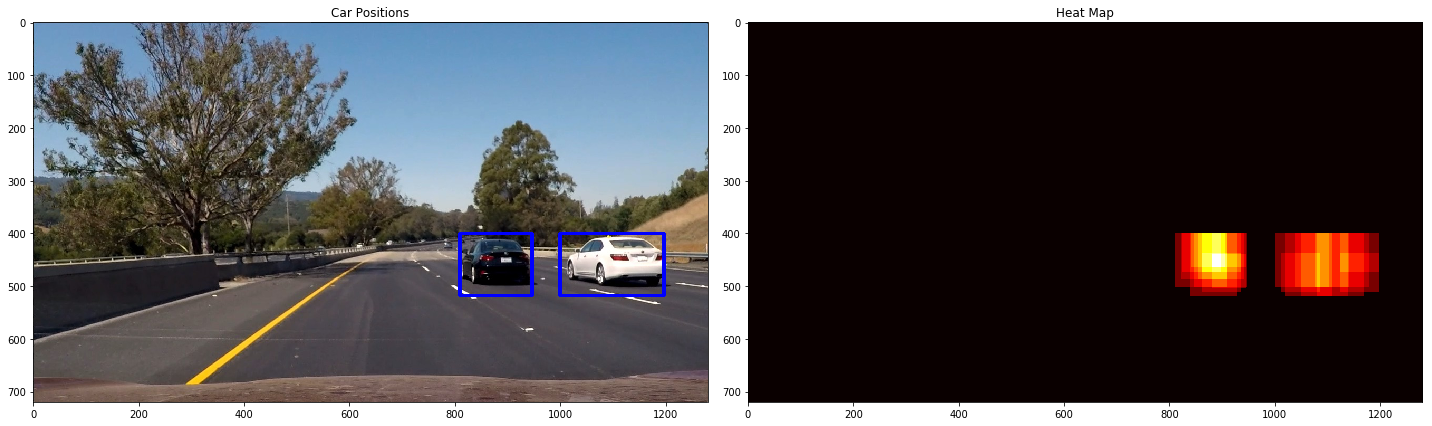

In [8]:
img = mpimg.imread('test_images/test6.jpg')
singleFilter = Filter(1, 2)
p_img = processImage(img, singleFilter, visualize=True)

## Video processing

In [11]:
videoFilter = Filter(5, 9)
def processImageForVideo(image):
    return processImage(image, videoFilter)


In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(processImageForVideo) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [33:20<00:01,  1.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 31min 42s, sys: 2min 1s, total: 33min 43s
Wall time: 33min 21s


## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

I think the biggest issue I faced was to optimize the classifier for speed. The original implementation took 12 minutes to process 2 seconds of video. After reducing feature size and increasing step sizes for sliding window search, I was able to improve the speed by more than 10x. However I think this still needs at least an order of magnitude improvement in speed to allow real-time processing.

I've also noticed that SVM incorrectly classifies the middle of road as cars, it seems a random fluctuation in gradients can cause the classifier to be confused when it uses HOG as the primary mean of classification.